Since its emergence in Asia late 2019, the coronavirus COVID-19 pandemic has been devastating. The virus spread to most countries causing severe respiratory infections and many human casualties. The virus also put half of the world population in lockdown which resulted in a slowdown of the world economy and a fall in stock prices.

The goal of this tutorial is to introduce the steps for collecting and analyzing stock data in the context of the coronavirus pandemic. To do this, we will use Python, Google Sheets and Google Finance.

In section 2 of the the tutorial, we will see how to configure Google Sheets in order to be able to interact with them using Python. In section 3, we will see how to collect stocks data using Google Finance and how to store this data in Google Sheets using Python. In section 4, we will see how to read the data from Google Sheets and analyze it using Python and Pandas.

The source code for this tutorial can be found in this [github repository](https://github.com/adilmoujahid/coronavirus-covid19-stocks-analysis).

# 1. The Case Study

In this tutorial, we will focus on the S&P 500 companies. We will start by collecting the following data :
* Stock prices in 3 different dates (January 1st, March 23rd and April 9th) 
* Number of outstanding shares for each company
* Industry/Sector where the companies operate (following the GICS classification)

After collecting and structuring the data, we will use ```Python``` and ```Pandas``` library to analyse the data.

# 2. Technical Setup

We will be using the following services and libraries to collect and analyze the data:

* Wikipedia: We will use [this wikipedia page](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies) to get the list of S&P 500 companies.
* Google Finance: Google Finance is a website focusing on business news and financial information hosted by Google [1]. Google Finance doesn't have an API that we can use directly in Python, but it can be accessed from Google Sheets using a formula called GOOGLEFINANCE. We will use Python to write down the GOOGLEFINANCE formulas.
* Goole Sheets: We will use Google Sheets as a backend to store stocks data. In order to interact with Google Sheets directly from Python, we need 3 libaries: [Google Auth](https://github.com/googleapis/google-auth-library-python), [gspread](https://gspread.readthedocs.io/en/latest/) and [gspread-pandas](https://gspread-pandas.readthedocs.io/en/latest/). We also need to configure Google Sheets to be able to access the spreadsheets using Python.
* Python and Jupyter notebooks and Pandas: We will be using Python, Jupyter notebooks and Pandas to collect, store and analyze the data.

![Alt Text](./images/data_flow.png)

## 2.1. Google Sheets Configuration in GCP

In order to access Google Sheets from Python, we need a private key from Google Cloud Platfrom (GCP) that we can obtain using the following steps.

* Step 1: Go to [Google Cloud platform](https://cloud.google.com/), log in using your google account and click on ```Console```.

![Alt Text](./images/gcp_config_1.png)

* Step 2: Click on ```Select a project``` > ```NEW PROJECT```, enter the project name and click on ```CREATE```

![Alt Text](./images/gcp_config_2.png)

* Step 3: Click on ```APIs & Services``` > ```Dashboard``` > ```ENABLE APIS AND SEVICES```.

![Alt Text](./images/gcp_config_3.png)

* Step 4: Search for both Google Drive API and Google Sheets API and click on ```ENABLE```

![Alt Text](./images/gcp_config_4.png)

* Step 5: Inside the Google Sheets API page, click on ```MANAGE```, ```CREATE CREDENTIALS``` and select ```Google Sheets API```.

![Alt Text](./images/gcp_config_5.png)

* Step 6: Choose ```Web sever```, ```Application data``` and ```JSON``` type for the API key. Click ```Continue``` to download your private key in JSON format.

![Alt Text](./images/gcp_config_6.png)

* Step 7: Once you download the JSON file, save in the same folder as your Jupyter notebook and copy the ```client_email``` information. 

![Alt Text](./images/gcp_config_7.png)

## 2.2. Google Sheets Configuration

As a last step, we need to create a new Google sheet and share it with the ```client_email``` that we created in the previous step. Open Google Drive, create a new Google Sheet, change its name to "stocks-data". Click on ```Share``` button, enter the ```client_email``` and click ```Send```.

![Alt Text](./images/gs_config.png)

# 3. Collecting and Storing Stocks Data

Now that we have our google Sheets configured, we can start using ```Python``` and ```Jupyter Notebook``` to collect the data. We start by importing the different libraries that we need.

In [23]:
%matplotlib inline

In [97]:
import pandas as pd
import gspread
from google.oauth2.service_account import Credentials
from gspread_pandas import Spread, Client

import seaborn as sns 
import matplotlib.pyplot as plt

In [137]:
plt.style.use('fivethirtyeight')

### Getting the list of S&P 500 companies from Wikipedia

As a first step in the data collection effort, we need to get the list of S&P 500 companies. To do this, we will use the following Wikipedia Page: [https://en.wikipedia.org/wiki/List_of_S%26P_500_companies](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies)

![Alt Text](./images/snp_500.png)

Fortunatey, we can use ```Pandas``` to read the page, extract the table with S&P 500 companies and store them into a ```Pandas``` Dataframe.

In [25]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

stocks_df = pd.read_html(url, header=0)[0]

stocks_df.head()

,Symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",1976-08-09,66740,1902
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,ABBV,AbbVie Inc.,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABMD,ABIOMED Inc,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


The most important data that we need is:
* Symbol: Stock Symbol 
* Security: Name of the company
* GICS Sector: Sector where the company operates following the Global Industry Classification Standard (GICS).
* GICS Sub Industry: Sub industry where the company operates following the Global Industry Classification Standard (GICS).

We can start looking at some statistics. For example the number of companies in the list.

In [26]:
#Number of companis
len(stocks_df)

505

We got 505 companies in our list, and not 500... This is because some companies have a dual-class stock structure and are listed more than once in the  list. We can get the list of these companies by searching for the word "Class" in their security name.

In [27]:
stocks_df[stocks_df['Security'].str.contains("Class")]

,Symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Headquarters Location,Date first added,CIK,Founded
24,GOOGL,Alphabet Inc Class A,reports,Communication Services,Interactive Media & Services,"Mountain View, California",2014-04-03,1652044,1998
25,GOOG,Alphabet Inc Class C,reports,Communication Services,Interactive Media & Services,"Mountain View, California",2006-04-03,1652044,1998
148,DISCA,Discovery Inc. Class A,reports,Communication Services,Broadcasting,"Silver Spring, Maryland",2010-03-01,1437107,NaN
149,DISCK,Discovery Inc. Class C,reports,Communication Services,Broadcasting,"Silver Spring, Maryland",2014-08-07,1437107,NaN
203,FOXA,Fox Corporation Class A,reports,Communication Services,Movies & Entertainment,"New York, New York",2013-07-01,1308161,NaN
204,FOX,Fox Corporation Class B,reports,Communication Services,Movies & Entertainment,"New York, New York",2015-09-18,1308161,NaN
340,NWSA,News Corp. Class A,reports,Communication Services,Publishing,"New York, New York",2013-08-01,1564708,NaN
341,NWS,News Corp. Class B,reports,Communication Services,Publishing,"New York, New York",2015-09-18,1564708,NaN
457,UAA,Under Armour Class A,reports,Consumer Discretionary,"Apparel, Accessories & Luxury Goods","Baltimore, Maryland",2014-05-01,1336917,NaN
458,UA,Under Armour Class C,reports,Consumer Discretionary,"Apparel, Accessories & Luxury Goods","Baltimore, Maryland",2016-04-08,1336917,NaN


We got 10 companies with dual-class structure in the list. If we take that into consideration, we can see that we have 500 unique companies in the list.

We can also check the number of companies by sector and sub industry.

In [28]:
stocks_df['GICS Sector'].value_counts()

Industrials               71
Information Technology    71
Financials                66
Consumer Discretionary    64
Health Care               60
Consumer Staples          33
Real Estate               31
Utilities                 28
Materials                 28
Energy                    27
Communication Services    26
Name: GICS Sector, dtype: int64

In [29]:
stocks_df['GICS Sub Industry'].value_counts()

Health Care Equipment       19
Electric Utilities          13
Semiconductors              13
Industrial Machinery        13
Packaged Foods & Meats      12
                            ..
Real Estate Services         1
Motorcycle Manufacturers     1
Multi-Sector Holdings        1
Hotel & Resort REITs         1
Drug Retail                  1
Name: GICS Sub Industry, Length: 128, dtype: int64

### Adding stocks data from Google Finance

Now that we have the list of S&P 500 companies, we can add to our DataFrame Google Sheets formulas that will fetch from Google Finance stock prices and the number of outstanding shares for each company. Note that, these formulas will be executed once we save the Pandas DataFrame in our Google Sheet.

You can find the documentation of GOOGLEFINANCE formulas here: https://support.google.com/docs/answer/3093281

We start by adding stock prices in 3 different dates: January 1st, March 23rd and April 9th.
   
* January 1st, 2020 is the first date of the year. We want to have this price in order to calculate the price drop since the beggining of 2020.
* March 23rd, 2020 is the date when the S&P 500 reached the bottom in 2020.
* April 9th, 2020 is the last date when the stock market was open (at the time of writing this blog post)

In [30]:
stocks_df["Price_1_1"] = stocks_df["Symbol"].apply(lambda x: '=INDEX(GOOGLEFINANCE("' + x + '","price", "1/1/2020"),2,2)')
stocks_df["Price_3_23"] = stocks_df["Symbol"].apply(lambda x: '=INDEX(GOOGLEFINANCE("' + x + '","price", "3/23/2020"),2,2)')
stocks_df["Price_4_9"] = stocks_df["Symbol"].apply(lambda x: '=INDEX(GOOGLEFINANCE("' + x + '","price", "4/9/2020"),2,2)')

Next, we add the formula to calculate the number of outstanding shares for each company. We can use this data with the stock prices to calculate the market cap of companies at the 3 different dates. 

In [31]:
stocks_df["Shares"] = stocks_df["Symbol"].apply(lambda x: '=GOOGLEFINANCE("' + x + '","shares")')

### Storing the DataFrame to Google Sheet

We start by creating a variable that contains our credentials that we got from Google Cloud Plaltform.

In [32]:
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

credentials = Credentials.from_service_account_file('./gsheet-stocks.json', scopes=scope)

Next, we read the empty google sheet in a variable that we call ```spread```. 

In [33]:
client = Client(scope=scope, creds=credentials)
spread = Spread("stocks_analysis", client=client)

We define the list of variables that we want to keep.

In [34]:
cols_to_keep = ["Symbol", "Security", "GICS Sector", "GICS Sub Industry", 
                "Price_1_1", "Price_3_23", "Price_4_9", "Shares"]

The last step is to save the DataFrame to Google Sheets.

In [35]:
spread.df_to_sheet(stocks_df[cols_to_keep])

If we go to Google Sheets, we can see that the data is correctly stored.

![Alt Text](./images/gs_data.png)

# 4. Analyzing the Data

## 4.1. Reading the data

We start by reading the data from Google Sheets into a new DataFrame.

In [36]:
stocks_df = spread.sheet_to_df()

In [37]:
stocks_df.head()

,Symbol,Security,GICS Sector,GICS Sub Industry,Price_1_1,Price_3_23,Price_4_9,Shares
index,,,,,,,,
0,MMM,3M Company,Industrials,Industrial Conglomerates,180,117.87,147.78,575261000
1,ABT,Abbott Laboratories,Health Care,Health Care Equipment,86.95,62.82,86.04,1763433000
2,ABBV,AbbVie Inc.,Health Care,Pharmaceuticals,89.55,64.5,79.75,1476673000
3,ABMD,ABIOMED Inc,Health Care,Health Care Equipment,168.81,132.34,160.08,45063000
4,ACN,Accenture plc,Information Technology,IT Consulting & Other Services,210.15,143.69,177.92,637027000


we can see that the DataFrame contains real values for stocks prices and number of shares (and not Google Sheets formulas).

We need to change the data type of stock prices and number of outstanding shares from ```string``` to ```numeric```.

In [48]:
stocks_df[["Price_1_1", "Price_3_23", "Price_4_9", "Shares"]] = \
stocks_df[["Price_1_1", "Price_3_23", "Price_4_9", "Shares"]].apply(pd.to_numeric)

## 4.2. Adding Market Cap data and percentage change of stock prices

### Adding Market Cap Data

Next, we will add the market cap in the 3 different dates.

In [53]:
stocks_df["Marketcap_1_1"] = stocks_df["Price_1_1"] * stocks_df["Shares"]
stocks_df["Marketcap_3_23"] = stocks_df["Price_3_23"] * stocks_df["Shares"]
stocks_df["Marketcap_4_9"] = stocks_df["Price_4_9"] * stocks_df["Shares"]

### Adding percentage change of stock prices

In [60]:
# Percentage Change from January 1st to March 23rd 
stocks_df["PercentageChange_3_23_1_1"] = (stocks_df["Price_3_23"] - stocks_df["Price_1_1"]) / stocks_df["Price_1_1"]*100
# Percentage Change from March 23rd to April 9th
stocks_df["PercentageChange_4_9_3_23"] = (stocks_df["Price_4_9"] - stocks_df["Price_3_23"]) / stocks_df["Price_3_23"]*100
# # Percentage Change from January 1st to April 9th
stocks_df["PercentageChange_4_9_1_1"] = (stocks_df["Price_4_9"] - stocks_df["Price_1_1"]) / stocks_df["Price_1_1"]*100

## 4.3. Analyzing the data

### Change in the total market cap of the S&P 500

In [62]:
sum(stocks_df["Marketcap_3_23"] - stocks_df["Marketcap_1_1"]) / 10**9

-8713.69057696208

In [63]:
sum(stocks_df["Marketcap_4_9"] - stocks_df["Marketcap_3_23"]) / 10**9

4668.79088967648

In [65]:
sum(stocks_df["Marketcap_4_9"] - stocks_df["Marketcap_1_1"]) / 10**9

-4044.8996872855996

The S&P 500 lost 8.7 trillion USD from January 1st to March 23rd, but it got back 4.6 trillion from March 23rd to April 9th.

### Change in the total market cap by sector

In [149]:
(stocks_df.groupby("GICS Sector").sum()["Marketcap_3_23"] - stocks_df.groupby("GICS Sector").sum()["Marketcap_1_1"]).sort_values() / 10**9

GICS Sector
Information Technology   -1592.206753
Financials               -1518.712229
Industrials              -1087.991664
Health Care              -1031.715099
Consumer Discretionary    -793.938427
Communication Services    -734.977458
Energy                    -710.786571
Consumer Staples          -450.846959
Real Estate               -265.205780
Materials                 -264.696109
Utilities                 -262.613530
dtype: float64

At the 2020 bottom of the S&P 500 (March 23rd), the Information Technology and Financials sectors had the largest drop in total market cap (compared to January 1st) with 1.592 trillion and 1.518 trillion respectively. 

In [150]:
(stocks_df.groupby("GICS Sector").sum()["Marketcap_4_9"] - stocks_df.groupby("GICS Sector").sum()["Marketcap_1_1"]).sort_values() / 10**9

GICS Sector
Financials               -870.187706
Industrials              -691.882829
Information Technology   -559.803630
Energy                   -510.373229
Communication Services   -401.445690
Consumer Discretionary   -397.755029
Health Care              -269.510749
Consumer Staples         -138.054799
Materials                -110.571043
Real Estate               -55.584791
Utilities                 -39.730193
dtype: float64

As of April 9th, we can see that the Financials and Industrials sector had the largest drop in total market cap compared to January 1st. 

### Ranking of companies by percentage change of stock prices

In [73]:
stocks_df.sort_values(by=["PercentageChange_4_9_1_1"])[["Security", "PercentageChange_4_9_1_1"]].head(5)

,Security,PercentageChange_4_9_1_1
index,,
352,Norwegian Cruise Line Holdings,-77.715451
90,Carnival Corp.,-75.794192
409,Royal Caribbean Cruises Ltd,-70.129967
303,Marathon Oil Corp.,-69.883041
346,Noble Energy Inc,-68.876917


We can see from the table above that the companies that are hardest hit are the 3 major cruises companies: Norwegian Cruise Line Holdings, Carnival Corp., Royal Caribbean Cruises Ltd. These companies saw drops in their stock price of over 70%.

In [159]:
print(sum(stocks_df["PercentageChange_4_9_1_1"] < 0))
print(sum(stocks_df["PercentageChange_4_9_1_1"] > 0))

449
56


Only 56 stocks form the 505 saw positive growth from January 1st to April 9th.

### Percentage Change of stock priced by sector

In [108]:
stocks_df.groupby("GICS Sector").mean()['PercentageChange_4_9_1_1'].sort_values()

GICS Sector
Energy                   -49.838483
Consumer Discretionary   -32.364198
Financials               -25.090248
Industrials              -23.928685
Communication Services   -20.003368
Materials                -17.806975
Information Technology   -15.412405
Real Estate              -14.374746
Health Care               -8.395149
Consumer Staples          -8.243594
Utilities                 -6.477197
Name: PercentageChange_4_9_1_1, dtype: float64

We can see that the energy sector was the hardest hit with a 49.8% average drop in stock prices.

Below we can visualize a boxplot of the 11 sectors' percentage change in stock prices from January 1st to April 9th.

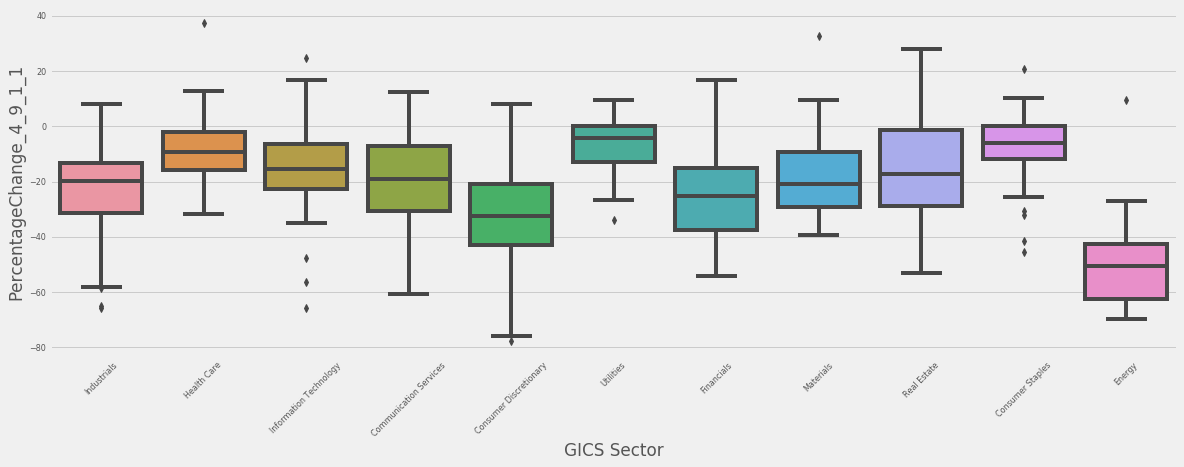

In [138]:
plt.figure(figsize=(18, 6))
plt.tick_params('both', labelsize='8')
plt.xticks(rotation=45)
sns.boxplot(x="GICS Sector", y="PercentageChange_4_9_1_1", data=stocks_df)

In [151]:
stocks_df.groupby("GICS Sub Industry").mean()['PercentageChange_4_9_1_1'].sort_values()

GICS Sub Industry
Hotels, Resorts & Cruise Lines        -61.709685
Oil & Gas Equipment & Services        -58.043026
Oil & Gas Drilling                    -57.631986
Airlines                              -53.542246
Department Stores                     -53.265702
                                         ...    
Food Retail                             8.374040
Wireless Telecommunication Services     9.301438
Metal & Glass Containers                9.486537
Water Utilities                         9.608985
Gold                                   32.600648
Name: PercentageChange_4_9_1_1, Length: 128, dtype: float64

In [155]:
print(sum(stocks_df.groupby("GICS Sub Industry").mean()['PercentageChange_4_9_1_1'] < 0))
print(sum(stocks_df.groupby("GICS Sub Industry").mean()['PercentageChange_4_9_1_1'] > 0))

118
10


if we look at the average percentage change in stock prices by Sub Industry; we can see that the travel related industries, Oil & Gas and Department Stores were the hardest hit. 118 of the 138 Sub Industries had their average stock price declined from January 1st to April 9th.

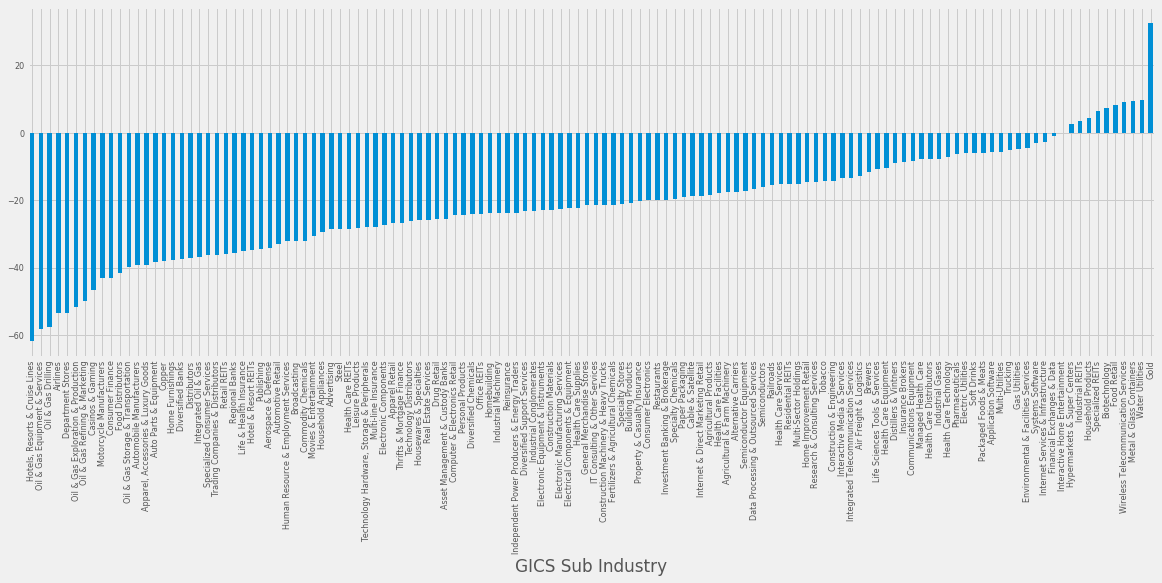

In [140]:
plt.figure(figsize=(18, 6))
plt.tick_params('both', labelsize='8')
stocks_df.groupby("GICS Sub Industry").mean()['PercentageChange_4_9_1_1'].sort_values().plot.bar()

### Percentage Change of stock priced by sector (From March 23rd to April 9th)

In [156]:
stocks_df.groupby("GICS Sector").mean()['PercentageChange_4_9_3_23'].sort_values()

GICS Sector
Communication Services    17.908378
Consumer Staples          21.212689
Information Technology    22.503612
Health Care               28.291532
Industrials               28.485595
Consumer Discretionary    33.247166
Utilities                 35.572216
Financials                35.613067
Real Estate               36.756680
Materials                 36.822111
Energy                    44.655048
Name: PercentageChange_4_9_3_23, dtype: float64

### Percentage Change of stock priced by Sub Industry (From March 23rf to April 9th)

In [94]:
stocks_df.groupby("GICS Sub Industry").mean()['PercentageChange_4_9_3_23'].sort_values()

GICS Sub Industry
Food Retail                       -0.064350
Drug Retail                        0.848429
Hypermarkets & Super Centers       5.825800
Interactive Home Entertainment     8.869739
Hotel & Resort REITs              11.516854
                                    ...    
Copper                            51.948052
Real Estate Services              52.899765
Diversified Chemicals             55.535296
Distributors                      62.086331
Household Appliances              63.111180
Name: PercentageChange_4_9_3_23, Length: 128, dtype: float64

All sectors and sub industries (except Food Retail) saw their average stock price go up from March 23rd to April 9th.

# Conclusion

In this tutorial, we learned how to use Python, Google Sheets and Google Finance to collect and analyze stock data in the context of coronavirus pandemic. We're still in the early stages of the pandemic, and we don't know yet what would be the mid to long term effect of the pandemic on both the society and the economy. It would be interesting to review this analysis in the coming weeks to see if the stock market recovers from the 2020 losses.

The source code for this tutorial can be found in this [github repository](https://github.com/adilmoujahid/coronavirus-covid19-stocks-analysis).

# References

[1] https://en.wikipedia.org/wiki/Google_Finance